In [1]:
# let's just play around with lmfit a bit, albeit
# the general structure to be used in TRKR fitting
# maybe work up to the same sort of fit but with fake data
#
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Pandas-lmfit helper functions

In [2]:
import numpy as np
import pandas as pd
from lmfit import minimize

def df_extract_dataset_indexed_matrices(df, column_names):
    """
    Given a pandas dataframe and a list of column names, returns
    a list of 2D numpy arrays corresponding to the data in each
    named column. Shape of matrix is given by multi-index:
    (# outer indices, # rows / inner indices per outer index)
    where it is expected that each outer index labels the
    same number of rows. If the dataframe does not have a
    multi-index, the resulting matrix has one row.
    
    The number of multi-index levels should not exceed 2.
    This function is intended for use in plugging multiple
    datasets into an equation at once, e.g. for cross-linked
    fitting.

    This function is _exceptionally_ fast if the inner index
    values are the same for each outer index (allowing a 2D array
    to be generated as simply "df.unstack()[column_name].values")

    e.g.  input parameters:
          df =                     [data columns]
          index_2d  index_1d       name    value     ...
                 0         0        'A'        1     ...
                 0         1        'B'        2     ...
                 1         0        'C'        3     ...
                 1         1        'D'        3     ...
                 2         0        'E'        2     ...
                 2         1        'F'        4     ...
               ...       ...        ...      ...     ...
          
          column_names = ['name', 'value', ...]
          
          output: [np.array([['A', 'B'], ['C', 'D'], ['E', 'F']]),
                   np.array([[1, 2], [3, 3], [2, 4]]),
                   ...]
    """
    if df.index.nlevels > 2:
        raise ValueError("dataframe multiindex should not exceed 2 levels")
    elif df.index.nlevels == 2:
        dataset_indices = df.index.levels[-2]
        # construct by unstack() [requires repeating inner index]
        mats = [df.unstack()[colname].values.copy()
                for colname in column_names]
        # check shape of final matrix is correct, else reindex and repeat
        dataset_indexing = df.loc[dataset_indices[0]].index
        if ymat.shape[-1] != len(dataset_indexing):
            reindex_1d = lambda x: x.set_index(dataset_indexing)
            safe_df = df.groupby(level=-2).apply(reindex_1d)
            mats = [safe_df.unstack()[colname].values.copy()
                    for colname in column_names]
        return mats
    else:  # just upconvert vectors to one-row 2D arrays
        return [df[colname].values[np.newaxis, :].copy()
                for colname in column_names]


def df_extract_vector_lists_by_dataset(df, column_names):
    """
    Given a pandas dataframe and a list of column names, returns
    a list containing lists of the form:
    [column_1_array, column_2_array, ...]
    where the list corresponds to an outer index value in the given
    dataframe, and each array corresponds to all values of a
    named column with that outer index value.

    Resulting lists are returned in the order corresponding to
    the 2nd level of multiindex, given by df.index.levels[-2]

    e.g.  input parameters:
          df =                     [data columns]
          index_2d  index_1d       name    value     ...
                 0         0        'A'        1     ...
                 0         1        'B'        2     ...
                 1         0        'C'        3     ...
                 1         1        'D'        3     ...
                 2         0        'E'        2     ...
                 2         1        'F'        4     ...
               ...       ...        ...      ...     ...
          
          column_names = ['name', 'value', ...]
          
          output: [[np.array(['A', 'B']), np.array([1, 2])],
                   [np.array(['C', 'D']), np.array([3, 3])],
                   [np.array(['E', 'F']), np.array([2, 4])],
                   ...]
    """
    if df.index.nlevels > 2:
        raise ValueError("dataframe multiindex should not exceed 2 levels")
    elif df.index.nlevels == 2:
        dataset_indices = df.index.levels[-2]
        dataset_vecs_list = []
        for dataset_index in dataset_indices:
            dataset_df = df.loc[dataset_index]
            vecs = [dataset_df[colname].values.copy()
                    for colname in column_names]
            dataset_vecs_list.append(vecs)
        return dataset_vecs_list
    else:  # return one-dataset list
        return [[df[colname].values.copy()
                 for colname in column_names]]


def df_transform_dataset_df_to_fit_row(df, group_fit_params_dict,
                                       fit_params_to_add,
                                       column_aggregation_dict={},
                                       keep_const_columns=True):
    """
    Function to be used with DataFrame.groupby(level=-2) on a
    2-level-indexed dataframe to consolidate each
    outer-index-grouped dataset into a single row describing
    a fit performed on that dataset. By default, all columns
    will be kept if and only if they contain a constant value
    or an aggregation function is provided to handle that column.
    This will remove non-const data columns from fit automatically,
    which is likely what is wanted. Non-const columns can be kept
    via providing an aggregation function, and more columns can
    easily be dropped via "del df[colname]" if desired.

    Note that currently the resulting 1-row df is squeeze()'d
    in order to properly recombine into one row of the resulting
    dataframe after a groupby().apply() operation. So this function
    actually returns a series indexed by ordered column names.

    e.g. input parameters:
         df =                      x    y  bfield  elapsed_time
            index_2d  index_1d
                   4         0   1.0  0.1    40.0           0.0
                   4         1   1.5  0.3    40.0          10.0
                   4         2   2.0  0.5    40.0          20.0

         group_fit_params_list   ={..., 4: Parameters({'slope': 0.2,
                                                       'offset': 0.1}), ...}
         fit_params_to_add       =['slope']
         column_aggregation_dict ={'elapsed_time': lambda x: x.max()-x.min()}

         output (before squeeze()):
                        slope  bfield  elapsed_time
            index_2d  
                   4      0.2    40.0          20.0
    """
    new_df = df.head(1)
    for colname in list(new_df):
        if colname in column_aggregation_dict.keys():
            aggfcn = column_aggregation_dict[colname]
            new_df[colname] = aggfcn(df[colname])
            continue
        elif keep_const_columns:  # if const, no change needed
            first_value = df[colname].iloc[0]
            if all(df[colname] == first_value):
                continue
        del new_df[colname]
    dataset_index = df.index.get_level_values(level=-2)[0]
    fit_params = group_fit_params_dict[dataset_index]
    for param_name in fit_params_to_add:
        if param_name in fit_params.keys():
            param = fit_params[param_name]
            new_df[param_name] = param.value
            if param.stderr is not None:
                if param.stderr != 0:
                    param_error_str = param_name + '_error'
                    new_df[param_error_str] = param.stderr
    # groupby().apply() + squeeze() = 1-row-df -> series -> row-in-new-df
    # (returning a 1-row-df to apply() -> get doubled index, obnoxiously)
    # might need to revisit this sometime
    return new_df.squeeze()


def df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                *res_args,
                                column_aggregation_dict={},  # KEYWORDS ONLY!
                                keep_const_columns=True,
                                **res_kwargs):
    """
    Residuals function expected to take parameters
    (params, xvector1, xvector2, ..., yvector, *res_args, **res_kwargs)
    By default, drops all non-const columns in each dataset
    and adds all fit params to dataframe.
    """
    all_cols = independent_vars_columns + [measured_data_column]
    dataset_vecs_list = df_extract_vector_lists_by_dataset(df, all_cols)
    dataset_results_list = []  # will be in order of multiindex' outer indexing
    dataset_fit_params_list = []
    for vecs in dataset_vecs_list:
        xvecs = vecs[:-1]
        yvec = vecs[-1]
        # TODO: add option to scalar-ize as many as all-but-one vectors if const?
        if yvec.size == 0:
            continue
        result = minimize(residuals_fcn, fit_params,
                          args=(*xvecs, yvec, *res_args),
                          kws=res_kwargs)
        dataset_results_list.append(result)
        dataset_fit_params_list.append(result.params)
    dataset_indices = df.index.levels[-2].values
    group_fit_params_dict = dict(zip(dataset_indices,
                                     dataset_fit_params_list))
    fit_params_to_add = list(result.params)
    dfgroups = df.groupby(level=-2)
    new_df = dfgroups.apply(df_transform_dataset_df_to_fit_row,
                            group_fit_params_dict,
                            fit_params_to_add,
                            column_aggregation_dict,
                            keep_const_columns)
    return dataset_results_list, new_df


def df_minimize_fcn_across_linked_datasets():
    pass





# Testing lmfit.minimize() with pandas on discrete, 1D datasets

NOTE: we call it "1D" but that's kind of confusing since the model fitfunction takes _two_ independent variables. In practice we always vary the first but keep the second constant. Specifically, we fit to new parameters each time we change the second variable. In fact, the very simple fit model would not be able to handle the behavior of actual 2D data. It's a 2D _function_, but not a 2D _model_.

## 1D Fit Model

In [3]:
# TODO: if this works well, spin this crap off into a pandas-lmfit-stuff-we-do helper package

# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def fitfcn_cosine(delay_time, b_external,  # <- independent vars,
                  gfactor,  # <- potentially linked parameters across datasets in run,
                  amplitude, phase_offset,  # <- rest are unlinked parameters unique to current dataset
                  y_offset):
    """
    Oversimplified cosine fit that assumes phase @t=0 is always 0.
    Expected to act on very few data points, so brings in expected ang. freq using b_external.

    Independent variables: delay_time (can vary), b_external (must be const.)
    Parameters: gfactor, amplitude, phase_offset, y_offset

    IMPORTANT NOTE: Despite this function taking more than one independent variable,
    this model is ONLY 1D. Only the first should be allowed to vary during a run,
    the other independent variables are there for convenience when fitting to pandas
    dataframes and should really be thought of more as constant parameters (scalar
    values are not only acceptable, they are preferred for speed reasons to the
    alternative - arrays of same shape as first independent variable)
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    pos_def_delay = delay_time % LASER_REPRATE
    signal = amplitude * np.cos(osc_ang_freq * pos_def_delay + phase_offset)
    return signal + y_offset


def residuals_fitfcn_cosine(params, delay_time, b_external, measured_data=None):
    """
    Residual wrapper for lmfit minimize() for function fitfcn_cosine.
    Uses given parameters and independent variables to evaluate function.
    If data is given, returns (data - function_output) for use in least
    squares optimization. If data is not given or None, just returns
    the function output.

    Follows the style used in the lmfit documentation on minimize().
    """
    # unpack parameters:
    #  extract .value attribute for each parameter
    param_values = params.valuesdict()
    gfactor      = param_values['gfactor']
    amplitude    = param_values['amplitude']
    phase_offset = param_values['phase_offset']
    y_offset     = param_values['y_offset']
    fitfcn_results = fitfcn_cosine(delay_time, b_external,
                                   gfactor, amplitude, phase_offset, y_offset)
    if measured_data is None:
        return fitfcn_results
    return fitfcn_results - measured_data


def pandas_residuals_fitfcn_cosine(params, dataframe,
                                   independent_vars_column_names,
                                   measured_data_column_name=None,
                                   check_for_const_bext=True,
                                   collapse_bext_to_scalar=True):
    """
    Wrapper for residuals_fitfcn_cosine to accept a pandas dataframe.

    Uses the dataframe and column names to extract numpy arrays which
    are forwarded to the wrapped function. Optionally, independent
    variables that the model does not expect to vary within a dataset
    can be checked to ensure a constant value and can even be collapsed
    to a scalar for faster processing.
    """
    # unpack pandas dataframe:
    delay_time_colname, b_external_colname = independent_vars_column_names
    delay_time_vals = dataframe[delay_time_colname].values
    b_external_vals = dataframe[b_external_colname].values
    # optional: throw an error if b_external column is not single-valued
    if check_for_const_bext:
        if np.any(b_external_vals != b_external_vals[0]):
            raise ValueError("pandas dataframe contained multiple values for " +
                             "'b_external', but this variable is expected " +
                             "to be constant in fit model 'fitfcn_cosine'.")
    # optional: convert b_external from vector to scalar for speed (since const.)
    if collapse_bext_to_scalar:
        b_external_vals = b_external_vals[0]
    fitfcn_results = fitfcn_cosine(delay_time_vals, b_external_vals,
                                   gfactor, amplitude, phase_offset, y_offset)    
    if measured_data_column_name is None:
        return fitfcn_results
    measured_data_vals = dataframe[measured_data_column_name].values
    return fitfcn_results - measured_data_vals



## Optional regularization wrapper

In [4]:
def regularization_residual_wrapper(params, residual_fcn, *residual_fcn_args,
                                    phs_offs_bending_regularization=False, phs_offs_bending_alpha=0.005,
                                    **residual_fcn_kwargs):
    residuals = residual_fcn(params, *residual_fcn_args, **residual_fcn_kwargs)
    return residuals

## 1D Parameter setup and constraints

In [5]:
from lmfit import Parameters

params_guesses = [('gfactor',        {'value' : 0.439,
                                      'vary'  : False}),
                  ('amplitude',      {'value' : 1e-3,
                                      'min'   : 0.0,
                                      'max'   : 1.0}),
                  ('phase_offset',   {'value' : 0.0,
                                      'min'   : -np.pi,
                                      'max'   : +np.pi}),
                  ('y_offset',       {'value' : 0.0,
                                      'min'   : -1e-3,
                                      'max'   : +1e-3}),
                 ]

fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)



## Fake data creation

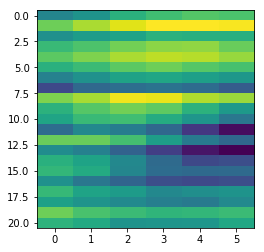

In [6]:
# create some fake data
ndatasets = 21
sweep_bvals = np.linspace(200, 208, ndatasets)
tvals = np.linspace(-500, -100, 6)

# CONUNDRUM: why does huge amts of data vs no data make almost
# no difference in ability to find phase_offset accurately!?
# but changing noise level makes gigantic difference...
#tvals = np.linspace(-2100, -100, 201)
#tvals = np.linspace(0, 10000, 1000)

amplitudes = 1e-3 + 5e-4 * np.cos((np.pi / 2) + (np.pi / 8) * np.arange(len(sweep_bvals)))
gfactor = 0.439
phase_offsets = (np.pi / 8) * np.cos((np.pi / 8) * np.arange(len(sweep_bvals)))
y_offsets = np.random.normal(size=len(sweep_bvals), scale=1e-3)
indices_1d = range(len(tvals))
indices_2d = range(len(sweep_bvals))
scan_1d_results= []
for index_2d in indices_2d:
    delay_times = tvals
    b_external = sweep_bvals[index_2d]
    amplitude = amplitudes[index_2d]
    gfactor = gfactor
    phase_offset = phase_offsets[index_2d]
    y_offset = y_offsets[index_2d]
    yvals = fitfcn_cosine(delay_times, b_external,
                          gfactor, amplitude, phase_offset, y_offset)
    noisy_yvals = yvals + np.random.normal(size=len(yvals), scale=1e-4)
    scan_1d_results.append(noisy_yvals)

X_bvals, X_tvals = np.meshgrid(sweep_bvals, tvals, indexing='ij',
                               sparse=False, copy=True)  # not sure on ideal settings here
independent_data_matrices = [X_tvals, X_bvals]
measured_data = np.array(scan_1d_results)
ndatasets = len(sweep_bvals)
nx = len(tvals)

plt.imshow(measured_data, interpolation='None', aspect=nx/ndatasets)

# pandas dataframe conversion
run_ids = np.zeros(measured_data.size, dtype=np.int)
indices_2d, indices_1d = np.meshgrid(np.arange(len(sweep_bvals)),
                                     np.arange(len(tvals)),
                                     indexing='ij', sparse=False, copy=True)
dataframe = pd.DataFrame({'run_id'        : run_ids,
                          'index_2d'      : indices_2d.flatten(),
                          'index_1d'      : indices_1d.flatten(),
                          'b_external'    : X_bvals.flatten(),
                          'probe_delay'   : X_tvals.flatten(),
                          'kerr_rotation' : measured_data.flatten(),
                         })
dataframe.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
dataframe.sort_index(ascending=True, inplace=True)  # not actually necessary, but nice to be sure
#dataframe.head(10)

## 1D Fit to fake data

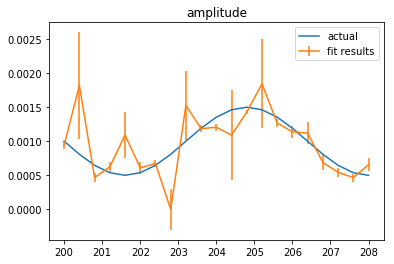

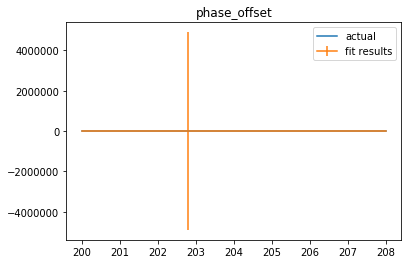

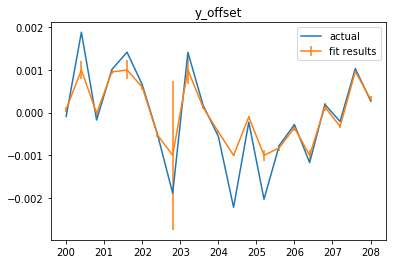

In [7]:
from lmfit import minimize, report_fit

# 1D FIT
results = []
for dataset_index in range(ndatasets):
    delay_time_vals = X_tvals[dataset_index]
    b_external_vals = X_bvals[dataset_index]
    measured_vals   = measured_data[dataset_index]
    result = minimize(residuals_fitfcn_cosine, fit_params,     # <- fitfcn & the Parameters() to be fit
                      args=(delay_time_vals, b_external_vals,  # <- other reqs of residuals fcn (i.e. X's, Y)
                            measured_vals),
                      kws={},                                  # <- keyword args for fit fcn, if any
                     )
    results.append(result)
#     if dataset_index == 3:
#         print(result.nfev)
#         yvals = subsubdf[data_column_name]
#         fityvals = residuals_fitfcn_cosine(result.params,
#                                            delay_time_vals, b_external_vals)
#         fitydiff = residuals_fitfcn_cosine(result.params,
#                                            delay_time_vals, b_external_vals,
#                                            measured_vals)
#         plt.plot(yvals, 'b')
#         plt.plot(fityvals, 'r')
#         plt.plot(fitydiff, 'g')

# # 1D FIT W/PANDAS
# independent_vars_column_names = ['probe_delay', 'b_external']
# data_column_name = 'kerr_rotation'
# subdf = dataframe.xs(0, level='run_id')
# results = []
# for dataset_index in range(ndatasets):
#     subsubdf = subdf.xs(dataset_index, level='index_2d')
#     result = minimize(pandas_residuals_fitfcn_cosine, fit_params,  # <- fitfcn & the Parameters() to be fit
#                       args=(subsubdf,                              # <- other reqs of residuals fcn
#                             independent_vars_column_names,
#                             data_column_name),
#                       kws={},                                      # <- keyword args for fit fcn, if any
#                      )
#     results.append(result)
#     if dataset_index == 3:
#         print(result.nfev)
#         yvals = subsubdf[data_column_name]
#         fityvals = pandas_residuals_fitfcn_cosine(result.params, subsubdf,
#                                                   independent_vars_column_names)
#         fitydiff = pandas_residuals_fitfcn_cosine(result.params, subsubdf,
#                                                   independent_vars_column_names,
#                                                   data_column_name)
#         plt.plot(yvals, 'b')
#         plt.plot(fityvals, 'r')
#         plt.plot(fitydiff, 'g')

paramname_realvalues_pairs = [
                              ('amplitude', amplitudes),
                              ('phase_offset', phase_offsets),
                              ('y_offset', y_offsets),
                             ]
for param_name, realvals in paramname_realvalues_pairs:
    matching_params = [result.params[param_name]
                       for result in results]
    param_vals = [param.value for param in matching_params]
    param_stderrs = [param.stderr for param in matching_params]
    plt.figure()
    plt.title(param_name)
    if len(sweep_bvals) == len(realvals):
        xvals = sweep_bvals
    else:
        xvals = np.arange(len(realvals))
    plt.plot(xvals, realvals, label='actual')
    if param_stderrs is not None:
        plt.errorbar(xvals, param_vals, param_stderrs, label='fit results')
    else:
        plt.plot(xvals, param_vals, label='fit results')
    plt.legend()
    plt.show()



In [8]:
df.head(10)

NameError: name 'df' is not defined

,b_external,gfactor,amplitude,amplitude_error,phase_offset,phase_offset_error,y_offset,y_offset_error
index_2d,,,,,,,,
0,200.0,0.439,0.000945,0.000058,0.252928,0.078952,0.000079,0.000055
1,200.4,0.439,0.001819,0.000781,0.738559,0.254511,0.001000,0.000202
2,200.8,0.439,0.000467,0.000065,-0.049422,0.161195,-0.000012,0.000058
3,201.2,0.439,0.000624,0.000073,0.077881,0.091944,0.000952,0.000054
4,201.6,0.439,0.001091,0.000333,0.175833,0.177269,0.001000,0.000223


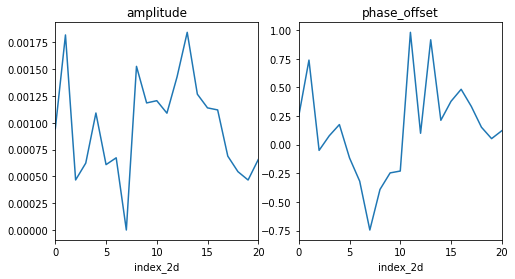

In [9]:
df = dataframe.loc[0]
residuals_fcn = residuals_fitfcn_cosine
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = "kerr_rotation"
fit_params_to_add = ['amplitude', 'phase_offset']
column_aggregation_dict = {'time_elapsed': lambda x: x.tail(1).values}
keep_const_columns = True

dataset_results, new_df = \
    df_minimize_fcn_on_datasets(df, residuals_fcn, fit_params,
                                independent_vars_columns,
                                measured_data_column,
                                column_aggregation_dict=column_aggregation_dict,  # keywords only!
                                keep_const_columns=keep_const_columns)
plt.figure(figsize=(8,4))
ax1 = plt.subplot(1,2,1)
new_df['amplitude'].plot.line(ax=ax1)
plt.title('amplitude')
ax2 = plt.subplot(1,2,2)
new_df['phase_offset'].plot.line(ax=ax2)
plt.title('phase_offset')
new_df.head()

# Testing lmfit.minimize() with pandas with cross-linked 1D datasets

NOTE: we call it "1D" but that's kind of confusing since the model fitfunction takes _two_ independent variables. In practice we always vary the first but keep the second constant. Specifically, we fit to new parameters each time we change the second variable. In fact, the very simple fit model would not be able to handle the behavior of actual 2D data. It's a 2D _function_, but not a 2D _model_.

## 1D Fit Model

In [129]:
# TODO: if this works well, spin this crap off into a pandas-lmfit-stuff-we-do helper package

# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

def fitfcn_cosine(delay_time, b_external,  # <- independent vars,
                  gfactor,  # <- potentially linked parameters across datasets in run,
                  amplitude, phase_offset,  # <- rest are unlinked parameters unique to current dataset
                  y_offset):
    """
    Oversimplified cosine fit that assumes phase @t=0 is always 0.
    Expected to act on very few data points, so brings in expected ang. freq.
    """
    osc_ang_freq = 2 * np.pi * GFACTORCONSTANT * gfactor * b_external
    pos_def_delay = delay_time % LASER_REPRATE
    signal = amplitude * np.cos(osc_ang_freq * pos_def_delay + phase_offset)
    return signal + y_offset


## Cross-Linked-Datasets Fit Model Expansion

In [130]:
def dataset_fitfcn_cosine(params, dataset_index, independent_data_vecs):
    """
    Given (params, dataset_index, independent_data_vecs), extracts from
    params the parameters relevant to dataset_index, then returns
    the calculated result of the fit function for the given independent_data_vecs
    (which should be a list of ndarrays of equal length, each corresponding to
    the same dataset as to which param_subset_index corresponds)     

    fitfunction: fitfcn_cosine
    fitfcn parameters: gfactor, amplitude, phase_offset, y_offset
    independent_data_vecs: [delay_time, b_external]
    """
    delay_time, b_external = independent_data_vecs
    gfactor      = params['gfactor_%i' % (dataset_index + 1)].value
    amplitude    = params['amplitude_%i' % (dataset_index + 1)].value
    phase_offset = params['phase_offset_%i' % (dataset_index + 1)].value
    y_offset     = params['y_offset_%i' % (dataset_index + 1)].value
    return fitfcn_cosine(delay_time, b_external,
                         gfactor, amplitude, phase_offset, y_offset)


def multidataset_residuals_fitfcn_cosine(params,
                                         independent_data_matrices,
                                         measured_data=None):
    """
    Calculates the summed residuals between the fits described by params and the
    'actual' results in measured_data.

    If the independent variables change between the different datasets being fit,
    each matrix in independent_data_matrices should have the same shape as
    measured_data, just corresponding to the values of an independent variable
    instead (think of it like the matrices np.meshgrid() outputs for each
    independent variable). If the independent variables are identical between
    the different datasets being fit, each matrix can simply be a 1D vector
    corresponding to any given row of measured_data.
    """
    dataset_fit_function = dataset_fitfcn_cosine
    if measured_data is None:
        xmatrices = np.broadcast_arrays(*independent_data_matrices)
    else:
        xymatrices = np.broadcast_arrays(*independent_data_matrices, measured_data)
        xmatrices = xymatrices[:-1]
        ymatrix = xymatrices[-1]
    ndatasets, nx = xmatrices[0].shape
    dataset_fitfcn_results = np.zeros((ndatasets, nx))
    for dataset_index in range(ndatasets):
        xvecs = [xmatrix[dataset_index, :]
                 for xmatrix in xmatrices]
        dataset_fitfcn_results[dataset_index, :] = dataset_fit_function(params, dataset_index, xvecs)
    if measured_data is None:
        return dataset_fitfcn_results
    residuals = ymatrix - dataset_fitfcn_results
    return residuals.flatten()






# TODO: test alternative approach to pandas functions:
# TODO:     \-> returns vectors/matrices to send to
# TODO:         non-pandas versions (for 1D/2D),
# TODO:         e.g. xvecs, yvec = pandas_df_extractor(df, dim=1, xcolnames, ycolname)
# TODO:              minimize(fcn, params, args=(xvecs, yvec))


# link these ^ v ?

# TODO: test using pivot tables of index_1d and index_2d followed
# TODO: by '.values' to group each column into an array of shape
# TODO: (ndatasets, nx) to send directly to residual fcn
# TODO: [or simpler, grab each column as series and unstack()]


# def extract_dataframe_xymatrices(params, dataframe,
#                                  independent_vars_column_names,
#                                  measured_data_column_name=None):



# def pandas_multidataset_residuals_fitfcn_cosine(params, dataframe,
#                                                 independent_vars_column_names,
#                                                 measured_data_column_name=None):
#     multidataset_residuals_function = multidataset_residuals_fitfcn_cosine
#     # unpack pandas dataframe:
#     indep_vars_column_vals = [dataframe[column_name]
#                               for column_name in independent_vars_column_names]
#     if data_column_name is None:
#         measured_data = None
#     else:
#         measured_data_column_vals = dataframe[measured_data_column_name]


#     return multidataset_residuals_function(params, independent_data_matrices, measured_data)

# def pandas_residuals_fitfcn_cosine(params, dataframe,
#                                    independent_vars_column_names,
#                                    data_column_name=None,
#                                    check_for_const_bext=True,
#                                    collapse_bext_to_scalar=True):
#     """
#     Wrapper for residuals_fitfcn_cosine to accept a pandas dataframe.

#     Uses the dataframe and column names to extract numpy arrays which
#     are forwarded to the wrapped function. Optionally, independent
#     variables that the model does not expect to vary within a dataset
#     can be checked to ensure a constant value and can even be collapsed
#     to a scalar for faster processing.
#     """
#     # unpack pandas dataframe:
#     delay_time_colname, b_external_colname = independent_vars_column_names
#     delay_time_vals = dataframe[delay_time_colname].values
#     b_external_vals = dataframe[b_external_colname].values
#     # optional: throw an error if b_external column is not single-valued
#     if check_for_const_bext:
#         if np.any(b_external_vals != b_external_vals[0]):
#             raise ValueError("pandas dataframe contained multiple values for " +
#                              "'b_external', but this variable is expected " +
#                              "to be constant in fit model 'fitfcn_cosine'.")
#     # optional: convert b_external from vector to scalar for speed (since const.)
#     if collapse_bext_to_scalar:
#         b_external_vals = b_external_vals[0]
#     fitfcn_results = fitfcn_cosine(delay_time_vals, b_external_vals,
#                                    gfactor, amplitude, phase_offset, y_offset)    
#     if data_column_name is None:
#         return fitfcn_results
#     data_vals = dataframe[data_column_name].values
#     return fitfcn_results - data_vals

## Optional regularization wrapper

In [131]:
def regularization_residual_wrapper(params, residual_fcn, *residual_fcn_args,
                                    phs_offs_bending_regularization=False, phs_offs_bending_alpha=0.005,
                                    **residual_fcn_kwargs):
    residuals = residual_fcn(params, *residual_fcn_args, **residual_fcn_kwargs)

    # since least-squares methods require an array of residuals,
    # just scale all values to add in extra error
    if phs_offs_bending_regularization:
        def scale_invariant_bending_energy(yvals):
            bending_energy = np.sum(np.diff(yvals, n=2)**2)
            bending_energy = bending_energy / (len(ys) - 2)
#            bending_energy = bending_energy / (np.sum(yvals**2) * (len(ys) - 2))  # scale invariance bad!
            return bending_energy
        matching_params = [val for key, val in result.params.items()
                           if 'phase_offset' in key]
        phase_offsets = np.array([param.value for param in matching_params])
        bending_energy = scale_invariant_bending_energy(phase_offsets)
        residual_norm = np.linalg.norm(residuals)  # the value that "matters" to fit algorithms
        penalty_factor = np.sqrt(1 + (phs_offs_bending_alpha * bending_energy / residual_norm)**2)
        residuals *= penalty_factor 

    return residuals

## Fake data creation

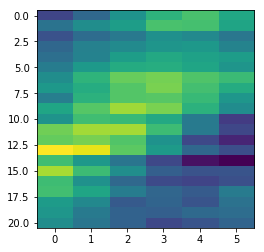

In [132]:
# create some fake data
ndatasets = 21
sweep_bvals = np.linspace(200, 208, ndatasets)
tvals = np.linspace(-500, -100, 6)

# CONUNDRUM: why does huge amts of data vs no data make almost
# no difference in ability to find phase_offset accurately!?
# but changing noise level makes gigantic difference...
#tvals = np.linspace(-2100, -100, 201)
#tvals = np.linspace(0, 10000, 1000)

amplitudes = 1e-3 + 5e-4 * np.cos((np.pi / 2) + (np.pi / 8) * np.arange(len(sweep_bvals)))
gfactor = 0.439
phase_offsets = (np.pi / 8) * np.cos((np.pi / 8) * np.arange(len(sweep_bvals)))
y_offsets = np.random.normal(size=len(sweep_bvals), scale=3e-4)
indices_1d = range(len(tvals))
indices_2d = range(len(sweep_bvals))
scan_1d_results= []
for index_2d in indices_2d:
    delay_times = tvals
    b_external = sweep_bvals[index_2d]
    amplitude = amplitudes[index_2d]
    gfactor = gfactor
    phase_offset = phase_offsets[index_2d]
    y_offset = y_offsets[index_2d]
    yvals = fitfcn_cosine(delay_times, b_external,
                          gfactor, amplitude, phase_offset, y_offset)
    noisy_yvals = yvals + np.random.normal(size=len(yvals), scale=1e-4)
    scan_1d_results.append(noisy_yvals)

X_bvals, X_tvals = np.meshgrid(sweep_bvals, tvals, indexing='ij',
                               sparse=False, copy=True)  # not sure on ideal settings here
independent_data_matrices = [X_tvals, X_bvals]
measured_data = np.array(scan_1d_results)
ndatasets = len(sweep_bvals)
nx = len(tvals)

plt.imshow(measured_data, interpolation='None', aspect=nx/ndatasets)

# pandas dataframe conversion
run_ids = np.zeros(measured_data.size, dtype=np.int)
indices_2d, indices_1d = np.meshgrid(np.arange(len(sweep_bvals)),
                                     np.arange(len(tvals)),
                                     indexing='ij', sparse=False, copy=True)
dataframe = pd.DataFrame({'run_id'        : run_ids,
                          'index_2d'      : indices_2d.flatten(),
                          'index_1d'      : indices_1d.flatten(),
                          'b_external'    : X_bvals.flatten(),
                          'probe_delay'   : X_tvals.flatten(),
                          'kerr_rotation' : measured_data.flatten(),
                         })
dataframe.set_index(['run_id', 'index_2d', 'index_1d'], drop=True, append=False, inplace=True)
dataframe.sort_index(ascending=True, inplace=True)  # not actually necessary, but nice to be sure
#dataframe.head(10)


## Cross-data-set parameter setup and constraints

In [133]:
from lmfit import Parameters

# create [ndatasets] sets of parameters, one per data set
params_guesses = [('gfactor',        {'value' : 0.439,
                                      'vary'  : False}),
                  ('amplitude',      {'value' : 1e-3,
                                      'min'   : 0.0,
                                      'max'   : 1.0}),
                  ('phase_offset',   {'value' : 0.0,
                                      'min'   : -np.pi,
                                      'max'   : +np.pi,
                                      'vary'  : True}),
                  ('y_offset',       {'value' : 0.0,
                                      'min'   : -1e-3,
                                      'max'   : +1e-3}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    for dataset_index in range(ndatasets):
        fit_params.add('%s_%i' % (param_name, dataset_index + 1), **param_guess_dict)

# add constraints
for dataset_index in range(1, ndatasets):
    # constrain all gfactors to be the same:
    fit_params['gfactor_%i' % (dataset_index + 1)].expr='gfactor_1'

    # constrain all phase offsets to be somewhat continuous
    this_label = 'phase_offset_%i' % (dataset_index + 1)
    last_label = 'phase_offset_%i' % dataset_index
    diff_label = 'phs_offs_diff_%i_minus_%i' % (dataset_index + 1, dataset_index)

    # method 1: unconstrained/soft-constrained differences
    fit_params.add(diff_label, vary=False,
                   expr=(this_label + '-' + last_label))

#     # method 2: hard-constrained differences
#     fit_params.add(diff_label, vary=True,
#                    value=0.0,
#                    min=-0.2*np.pi,
#                    max=+0.2*np.pi)
#     fit_params[this_label].vary = False
#     fit_params[this_label].expr = last_label + '+' + diff_label



In [134]:
list(fit_params)

['gfactor_1',
 'gfactor_2',
 'gfactor_3',
 'gfactor_4',
 'gfactor_5',
 'gfactor_6',
 'gfactor_7',
 'gfactor_8',
 'gfactor_9',
 'gfactor_10',
 'gfactor_11',
 'gfactor_12',
 'gfactor_13',
 'gfactor_14',
 'gfactor_15',
 'gfactor_16',
 'gfactor_17',
 'gfactor_18',
 'gfactor_19',
 'gfactor_20',
 'gfactor_21',
 'amplitude_1',
 'amplitude_2',
 'amplitude_3',
 'amplitude_4',
 'amplitude_5',
 'amplitude_6',
 'amplitude_7',
 'amplitude_8',
 'amplitude_9',
 'amplitude_10',
 'amplitude_11',
 'amplitude_12',
 'amplitude_13',
 'amplitude_14',
 'amplitude_15',
 'amplitude_16',
 'amplitude_17',
 'amplitude_18',
 'amplitude_19',
 'amplitude_20',
 'amplitude_21',
 'phase_offset_1',
 'phase_offset_2',
 'phase_offset_3',
 'phase_offset_4',
 'phase_offset_5',
 'phase_offset_6',
 'phase_offset_7',
 'phase_offset_8',
 'phase_offset_9',
 'phase_offset_10',
 'phase_offset_11',
 'phase_offset_12',
 'phase_offset_13',
 'phase_offset_14',
 'phase_offset_15',
 'phase_offset_16',
 'phase_offset_17',
 'phase_offset_

## Fit to fake data

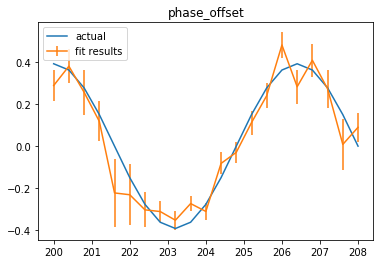

In [32]:
from lmfit import minimize, report_fit

# 1.5D FIT W/OUT PANDAS, REGULARIZATION
result = minimize(multidataset_residuals_fitfcn_cosine,       # <- residual of fitfcn & fit Parameters()
                  fit_params,
                  args=(independent_data_matrices,            # <- other reqs of residuals fcn (i.e. Xs & Y)
                        measured_data),
                  kws={}                                      # <- keyword args for fit fcn, if any
                 )
# report_fit(result.params)

# # 1.5D FIT W/OUT PANDAS, W/REGULARIZATION
# result = minimize(regularization_residual_wrapper, fit_params,  # <- regularization wrapper & fit Parameters()
#                   args=(multidataset_residuals_fitfcn_cosine,   # <- residual fcn to be regularized
#                         independent_data_matrices,              # <- other reqs of residuals fcn (i.e. Xs & Y)
#                         measured_data),
#                   kws={'phs_offs_bending_regularization' : False, # <- reg. keywords captured en route
#                        'phs_offs_bending_alpha'          : 3.0}   # to residual fcn, others pass through
#                  )
# # report_fit(result.params)

# # 1.5D FIT W/ PANDAS, W/OUT REGULARIZATION
# independent_vars_column_names = ['probe_delay', 'b_external']
# data_column_name = 'kerr_rotation'
# subdf = dataframe.xs(0, level='run_id')
# result = minimize(pandas_multidataset_residuals_fitfcn_cosine,# <- residual of fitfcn & fit Parameters()
#                   fit_params,
#                   args=(dataframe,                            # <- other reqs of residuals fcn (i.e. Xs & Y)
#                         independent_vars_column_names,
#                         data_column_name),
#                   kws={}                                      # <- keyword args for fit fcn, if any
#                  )
# # report_fit(result.params)

# # 1.5D FIT W/PANDAS, REGULARIZATION
# independent_vars_column_names = ['probe_delay', 'b_external']
# data_column_name = 'kerr_rotation'
# subdf = dataframe.xs(0, level='index_1d')
# result = minimize(regularization_residual_wrapper, fit_params,# <- regularization fcn & fit Parameters()
#                   args=(dataframe,                            # <- other reqs of residuals fcn
#                         independent_vars_column_names,
#                         data_column_name),
#                   kws={residual_fcn:
#                            pandas_multidataset_residuals_fitfcn_cosine,  # <- residual fcn to be regularized
#                        phs_offs_diff_regularization : False,  # <- regularization keywords captured en route
#                        phs_offs_diff_alpha          : 0.005}  #    to residual fcn, any others pass through
#                  )
# # report_fit(result.params)

paramname_realvalues_pairs = [
#                              ('amplitude', amplitudes),
                              ('phase_offset', phase_offsets),
#                              ('phs_offs_diff', np.diff(phase_offsets)),
#                              ('y_offset', y_offsets),
                             ]
for param_name, realvals in paramname_realvalues_pairs:
    matching_params = [val for key, val in result.params.items()
                       if param_name in key]
    param_vals = [param.value for param in matching_params]
    param_stderrs = [param.stderr for param in matching_params]
    plt.figure()
    plt.title(param_name)
    if len(sweep_bvals) == len(realvals):
        xvals = sweep_bvals
    else:
        xvals = np.arange(len(realvals))
    plt.plot(xvals, realvals, label='actual')
    if param_stderrs is not None:
        plt.errorbar(xvals, param_vals, param_stderrs, label='fit results')
    else:
        plt.plot(xvals, param_vals, label='fit results')
    plt.legend()
    plt.show()

# Potentially useful reference code

## Timing analysis for pandas access function options

In [422]:
df = dataframe
df = df.loc[0]
#df = df.loc[0]

In [416]:
# optional: change index_1d to be not the same between datasets
df = df.reset_index()
df['index_1d'] = df.index
df.set_index(['index_2d', 'index_1d'], append=False, drop=True, inplace=True)
#df.unstack()['b_external'].head()

In [423]:
%%timeit
# 2D pivot-style access of 2D structure
# METHOD 1: UNSTACK() WITHOUT GUARD
independent_vars_column_names = ["probe_delay", "b_external"]
data_column_name = "kerr_rotation"
if df.index.nlevels > 2:
    raise ValueError("dataframe multiindex should not exceed 2 levels")
elif df.index.nlevels == 2:
    # construct by unstack() [requires repeating inner index]
    xmats = [df.unstack()[colname].values.copy()
             for colname in independent_vars_column_names]
    ymat = df.unstack()[data_column_name].values.copy()
else:  # just upconvert vectors to one-row 2D arrays
    xmats = [df[colname].values[np.newaxis, :].copy()
             for colname in independent_vars_column_names]
    ymat = df[data_column_name].values[np.newaxis, :].copy()
xmats, ymat  # pretend to do something

3.5 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [424]:
%%timeit
# 2D pivot-style access of 2D structure
# METHOD 2: UNSTACK() WITH REINDEXING
independent_vars_column_names = ["probe_delay", "b_external"]
data_column_name = "kerr_rotation"
if df.index.nlevels > 2:
    raise ValueError("dataframe multiindex should not exceed 2 levels")
elif df.index.nlevels == 2:
    # ensure inner index repeats w/ groupby() [slow]
    dataset_indices = df.index.levels[-2].values
    dataset_indexing = df.loc[dataset_indices[0]].index
    reindex_1d = lambda x: x.set_index(dataset_indexing)
    safe_df = df.groupby(level=-2).apply(reindex_1d)

    # construct by unstack() [requires repeating inner index]
    xmats = [safe_df.unstack()[colname].values.copy()
             for colname in independent_vars_column_names]
    ymat = safe_df.unstack()[data_column_name].values.copy()
else:  # just upconvert vectors to one-row 2D arrays
    xmats = [df[colname].values[np.newaxis, :].copy()
             for colname in independent_vars_column_names]
    ymat = df[data_column_name].values[np.newaxis, :].copy()
xmats, ymat  # pretend to do something

17 ms ± 983 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [426]:
%%timeit
# 2D pivot-style access of 2D structure
# METHOD 3: UNSTACK() WITH GUARD
independent_vars_column_names = ["probe_delay", "b_external"]
data_column_name = "kerr_rotation"
if df.index.nlevels > 2:
    raise ValueError("dataframe multiindex should not exceed 2 levels")
elif df.index.nlevels == 2:
    # construct by unstack() [requires repeating inner index]
    xmats = [df.unstack()[colname].values.copy()
             for colname in independent_vars_column_names]
    ymat = df.unstack()[data_column_name].values.copy()

    # check shape of final matrix is correct, else reindex and repeat
    dataset_indices = df.index.levels[-2].values
    dataset_indexing = df.loc[dataset_indices[0]].index
    if ymat.shape[-1] != len(dataset_indexing):
        reindex_1d = lambda x: x.set_index(dataset_indexing)
        safe_df = df.groupby(level=-2).apply(reindex_1d)
        xmats = [safe_df.unstack()[colname].values.copy()
                 for colname in independent_vars_column_names]
        ymat = safe_df.unstack()[data_column_name].values.copy()
else:  # just upconvert vectors to one-row 2D arrays
    xmats = [df[colname].values[np.newaxis, :].copy()
             for colname in independent_vars_column_names]
    ymat = df[data_column_name].values[np.newaxis, :].copy()
xmats, ymat  # pretend to do something
xmats[0]

4.14 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [427]:
%%timeit
# 2D pivot-style access of 2D structure
# METHOD 4: NUMPY MATRIX CONSTRUCTION
independent_vars_column_names = ["probe_delay", "b_external"]
data_column_name = "kerr_rotation"
if df.index.nlevels > 2:
    raise ValueError("dataframe multiindex should not exceed 2 levels")
elif df.index.nlevels == 2:
    dataset_indices = df.index.levels[-2].values
    dataset_length = len(df.loc[dataset_indices[0]])
    n_datasets = len(dataset_indices)
    xmats = [np.zeros((n_datasets, dataset_length))
             for colname in independent_vars_column_names]
    ymat = np.zeros((n_datasets, dataset_length))
    for dataset_index in dataset_indices:
        for xmat, colname in zip(xmats, independent_vars_column_names):
            xmat[dataset_index, :] = df.loc[dataset_index][colname].values
        ymat[dataset_index, :] = df.loc[dataset_index][data_column_name].values
else:  # just upconvert vectors to one-row 2D arrays
    xmats = [df[colname].values[np.newaxis, :]
             for colname in independent_vars_column_names]
    ymat = df[data_column_name].values[np.newaxis, :]
xmats, ymat  # pretend to do something

30.3 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [389]:
%%timeit
# looped 1D access of 2D structure
independent_vars_column_names = ["probe_delay", "b_external"]
data_column_name = "kerr_rotation"
if df.index.nlevels > 2:
    raise ValueError("dataframe multiindex should not exceed 2 levels")
elif df.index.nlevels == 2:
    dataset_indices = df.index.levels[-2]
    dataset_length = len(df.loc[indices_2d[0]])
    dataset_xvecs_list = []
    dataset_yvec_list = []
    for dataset_index in dataset_indices:
        dataset_df = df.loc[dataset_index]
        if len(dataset_df) != dataset_length:
            raise ValueError("using 2-level multiindexed dataframe requires same " +
                             "# rows spanned by each outer index to ensure equal-" +
                             "length datasets")
        xvecs = [dataset_df[colname].values.copy()
                 for colname in independent_vars_column_names]
        yvec = dataset_df[data_column_name].values.copy()
        dataset_xvecs_list.append(xvecs)
        dataset_yvec_list.append(yvec)
else:
    xvecs = [df[colname].values.copy()
             for colname in independent_vars_column_names]
    yvec = df[data_column_name].values.copy()
    dataset_xvecs_list = [xvecs]
    dataset_yvec_list = [yvec]

10.4 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
# TESTING df_transform_dataset_df_to_fit_row

# params for test:
fit_params = fit_params
fit_params_to_add = ['amplitude', 'phase_offset']
columns_to_drop = ['kerr_rotation']
keep_const_columns = True
column_aggregation_dict = {'time_elapsed': lambda x: x.tail(1).values}

# test:
df = dataframe.loc[0]
df['lol'] = 'lol'
df['time_elapsed'] = 10.0 + (0.02 * df['probe_delay'])
assert df.index.nlevels == 2
dfg = df.groupby(level=-2, sort=False)
dfg.get_group(0)
# new_df = dfg.apply(df_transform_dataset_df_to_fit_row,
#                    result.params, fit_params_to_add,
#                    column_aggregation_dict)
# new_df

b_external  kerr_rotation  probe_delay  lol  time_elapsed
index_2d index_1d                                                           
0        0              200.0      -0.000379       -500.0  lol           0.0
         1              200.0       0.000344       -420.0  lol           1.6
         2              200.0       0.001036       -340.0  lol           3.2
         3              200.0       0.001241       -260.0  lol           4.8
         4              200.0       0.001374       -180.0  lol           6.4
         5              200.0       0.001200       -100.0  lol           8.0

In [146]:
df = dataframe.loc[0]
df = df.loc[0:0]  # the break from python syntax hurts my brain
# ^ simulate getting groupby result

fit_params = fit_params
fit_params_to_add = ['amplitude', 'phase_offset']
columns_to_drop = ["kerr_rotation"]
keep_const_columns = True
column_aggregation_dict = {"probe_delay": lambda x: x.head(1)}
# ^ simulate input options

new_df = df.head(1)
new_df = new_df.reset_index(level=-1, drop=True)
for colname in list(new_df):
    if colname in column_aggregation_dict.keys():
        aggfcn = column_aggregation_dict[colname]
        new_df[colname] = aggfcn(df[colname]).values
        continue
    elif keep_const_columns:  # if const, no change needed
        if colname not in columns_to_drop:
            first_value = df[colname].iloc[0]
            if all(df[colname] == first_value):
                continue
    del new_df[colname]
new_df



,b_external,probe_delay
index_2d,,
0,200.0,-500.0


## stackexchange code used as example for cross-linked set analysis

In [ ]:
# # EXAMPLE CODE: FITTING MULTIPLE DATASETS WITH SOME LINKED, SOME UNLINKED PARAMETERS

# # STACKEXCHANGE CODE
# # http://stackoverflow.com/questions/20339234/
# #                               python-and-lmfit-how-to-fit-multiple-datasets-with-shared-parameters
# from lmfit import minimize, Parameters, report_fit

# def gauss(x, amp, cen, sigma):
#     "basic gaussian"
#     return amp*np.exp(-(x-cen)**2/(2.*sigma**2))

# def gauss_dataset(params, i, x):
#     """calc gaussian from params for data set i
#     using simple, hardwired naming convention"""
#     amp = params['amp_%i' % (i+1)].value
#     cen = params['cen_%i' % (i+1)].value
#     sig = params['sig_%i' % (i+1)].value
#     return gauss(x, amp, cen, sig)

# def objective(params, x, data):
#     """ calculate total residual for fits to several data sets held
#     in a 2-D array, and modeled by Gaussian functions"""
#     ndata, nx = data.shape
#     resid = np.zeros_like(data)  # originally resid = 0.0*data[:]
#     # make residual per data set
#     for i in range(ndata):
#         resid[i, :] = data[i, :] - gauss_dataset(params, i, x)
#     # now flatten this to a 1D array, as minimize() needs
#     return resid.flatten()

# # create [ndata] datasets
# ndata = 6
# x  = np.linspace( -2, 2, 201)
# data = []
# for i in np.arange(ndata):
#     params = Parameters()
#     amp   =  5.00 + 2.50*(2*np.random.rand()-1)
#     cen   =  0.00 + 1.50*(2*np.random.rand()-1)
#     sig   =  0.25 + 0.03*(2*np.random.rand()-1)
#     dat   = gauss(x, amp, cen, sig) + np.random.normal(size=len(x), scale=0.1)
#     data.append(dat)

# # data has shape ([ndata], 201)
# data = np.array(data)
# assert(data.shape) == (ndata, 201)

# # create [ndata] sets of parameters, one per data set
# params_guesses = [('amp', {'value' : 5.0,
#                            'min'   : 0.0,
#                            'max'   : 200.0}),
#                   ('cen', {'value' : 0.0,
#                            'min'   : -2.0,
#                            'max'   : +2.0}),
#                   ('sig', {'value' : 0.3,
#                            'min'   : 0.01,
#                            'max'   : 3.00}),
#                  ]
# fit_params = Parameters()
# for param_name, param_guess_dict in params_guesses:
#     for iy, _ in enumerate(data):
#         fit_params.add('%s_%i' % (param_name, iy+1), **param_guess_dict)

# # but now constrain all values of sigma to have the same value
# # by assigning sig_2, sig_3, .. sig_5 to be equal to sig_1
# for iy in range(1,ndata):
#     fit_params['sig_%i' % (iy+1)].expr='sig_1'

# # run the global fit to all the data sets
# result = minimize(objective, fit_params, args=(x, data))
# report_fit(result.params)

# # plot the data sets and fits
# plt.figure()
# for i in range(ndata):
#     y_fit = gauss_dataset(result.params, i, x)
#     plt.plot(x, data[i, :], 'o', x, y_fit, '-')

# plt.show()

## testing measures of jaggnesness for regularization

In [ ]:

n = 20
ncols = 2
noisescales = [0.05, 0.1, 0.2]
plt.figure(figsize=(6,6))
for row, noisescale in enumerate(noisescales):
    for col in range(ncols):
        xs = np.linspace(0, 1, n)
        ys = np.sin(2 * np.pi * xs) + noisescale * np.random.randn(n)
        jaggedness = np.sum(np.diff(ys, n=2)**2)  # np.gradient instead?

        plt.subplot(len(noisescales), ncols, ncols * row + col + 1)
        plt.plot(xs, ys)
        plt.xticks([])
        plt.title(jaggedness)

In [ ]:
n = 16
ncols = 4
noisescales = [0.05, 0.1, 0.2]

def datafcn(xs, noisescale):
    signal = np.sin(2 * np.pi * xs)
    noise = noisescale * np.random.randn(len(xs))
    return signal + noise

# jaggednessfcn = lambda ys: np.sum(np.diff(ys, n=2)**2) / (len(ys) - 2)
jaggednessfcn = lambda ys: np.sum(np.gradient(np.gradient(ys))**2) / (len(ys) - 2)

plt.figure(figsize=(10,7))
for row, noisescale in enumerate(noisescales):
    xs = np.linspace(0, 1, n)
    ys = datafcn(xs, noisescale)
    
    plt.subplot(len(noisescales), ncols, ncols * row + 1)
    plt.plot(xs, ys)
    plt.xticks([]); plt.yticks([])
    plt.title(jaggednessfcn(ys))

    newxs = xs
    newys = ys
    for col in range(1, ncols):
        newxs = np.concatenate([newxs, xs + col], axis=0)
        newys = np.concatenate([newys, ys], axis=0)

        plt.subplot(len(noisescales), ncols, ncols * row + 1 + col)
        plt.plot(newxs, newys)
        plt.xticks([]); plt.yticks([])
        plt.title(jaggednessfcn(newys))

In [ ]:
n = 16
ncols = 4
noisescale = 0.1
scales = [1.0, np.sqrt(2), 2.0]

def datafcn(xs, noisescale):
    signal = np.sin(2 * np.pi * xs)
    noise = noisescale * np.random.randn(len(xs))
    return signal + noise

#jaggednessfcn = lambda ys: np.sum(np.diff(ys, n=2)**2) / (1 * (len(ys) - 2))
jaggednessfcn = lambda ys: np.sum(np.diff(ys, n=2)**2) / (np.sum(ys**2) * (len(ys) - 2))  # lucky guess!
# jaggednessfcn = lambda ys: np.sum(np.gradient(np.gradient(ys))**2) / (len(ys) - 2)

xs = np.linspace(0, 1, n)
ys_orig = scale * datafcn(xs, noisescale)
plt.figure(figsize=(10,7))
for row, scale in enumerate(scales):
    ys = scale * ys_orig
    
    plt.subplot(len(scales), ncols, ncols * row + 1)
    plt.plot(xs, ys)
    plt.xticks([]); plt.yticks([])
    plt.title(jaggednessfcn(ys))

    newxs = xs
    newys = ys
    for col in range(1, ncols):
        newxs = np.concatenate([newxs, xs + col], axis=0)
        newys = np.concatenate([newys, ys], axis=0)

        plt.subplot(len(scales), ncols, ncols * row + 1 + col)
        plt.plot(newxs, newys)
        plt.xticks([]); plt.yticks([])
        plt.title(jaggednessfcn(newys))